In [1]:
#Importing the necessary libraries
from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

# Calculating Cumulative Count Cut
def scaleCCC(x):
    return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x,2)))

#List of all the images
images_list=["2_P.tif"]
#images_list=["2_P.tif","2_A.tif","3_P.tif","3_A.tif","4_P.tif","4_A.tif","5_P.tif","5_A.tif","6_P.tif","6_A.tif","7_P.tif","7_A.tif","8_P.tif","8_A.tif","9_P.tif","9_A.tif","10_P.tif","10_A.tif","11_P.tif","11_A.tif","12_P.tif","12_A.tif","13_P.tif","13_A.tif", "14_P.tif", "14_A.tif", "15_P.tif", "15_A.tif"]
images_open =[]

# Opening the satellite images
for img_name in images_list:
  img_open = gdal.Open('./ALL_FLOOD/'+img_name)
  # Extracting individual bands(4,8,12) from the uploaded images
  band4 = img_open.GetRasterBand(1).ReadAsArray()
  band8 = img_open.GetRasterBand(2).ReadAsArray()
  band12 = img_open.GetRasterBand(3).ReadAsArray()
  ccc4 = scaleCCC(band4)
  ccc8 = scaleCCC(band8)
  ccc12 = scaleCCC(band12)
  # Creating a new images by combining the three bands 
  images_open.append(np.dstack((ccc4,ccc8,ccc12)))

all_images_array= images_open

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


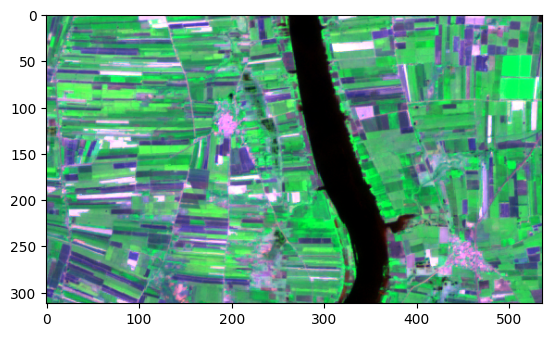

In [2]:
# Visualizing the images
for img in images_open:
  plt.figure()
  plt.imshow(img)
  plt.show()

In [3]:
# Reshaping the images

reshaped_images=[]
for i in range(len(all_images_array)):
  new_shape = (all_images_array[i].shape[0] * all_images_array[i].shape[1], all_images_array[i].shape[2])
  new_image = all_images_array[i][:, :, :3].reshape(new_shape)
  reshaped_images.append(new_image)

In [4]:
# Shape of the one image
print(reshaped_images[0].shape)

#concatenating all the arrays
combined_image = reshaped_images[0]
for i in range(1, len(reshaped_images)):
  combined_image = np.concatenate((combined_image, reshaped_images[i]), axis=0)

# Shape of the all images
print(combined_image.shape)

(167232, 3)
(167232, 3)


In [5]:
# Removing nan values
combined_image2 = np.nan_to_num(combined_image)

# K-Means clustering

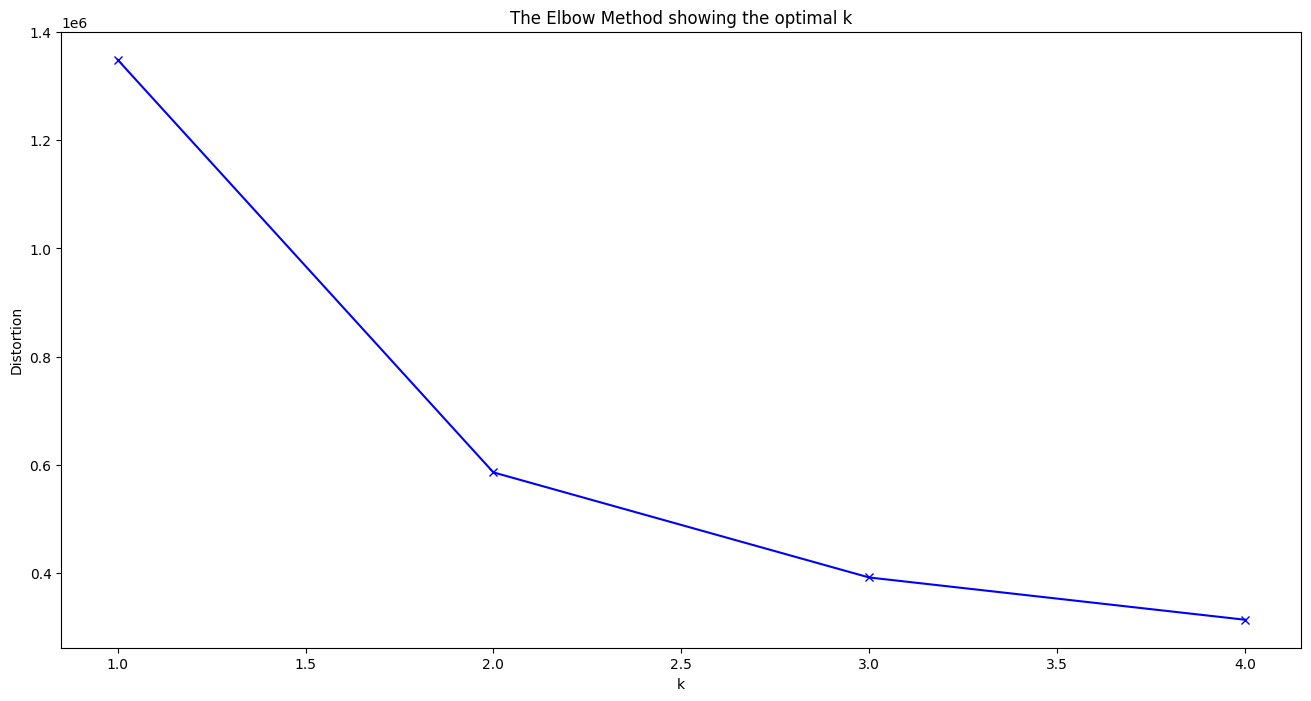

In [8]:
# Using Elbow-method to determine the optimum number of clusters for K-Means method

from sklearn.cluster import KMeans
distortions = []

K = range(1,5)
for k in K:
    kmeanModel = KMeans(n_clusters=k)
    kmeanModel.fit(combined_image2)
    distortions.append(kmeanModel.inertia_)

plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [9]:
# Applying K-Means algorithm
from sklearn.cluster import KMeans

k_means = KMeans(n_clusters=3)
trained_kmeans= k_means.fit(combined_image2)
image_cluster = trained_kmeans.labels_

In [11]:
#List of all the images
images_test=["1_P.tif","1_A.tif"]
images_open_test =[]

# Opening the satellite images
for img_name in images_test:
  img_open = gdal.Open('./ALL_FLOOD/'+img_name)
  # Extracting individual bands(4,8,12) from the uploaded images
  band4 = img_open.GetRasterBand(1).ReadAsArray()
  band8 = img_open.GetRasterBand(2).ReadAsArray()
  band12 = img_open.GetRasterBand(3).ReadAsArray()
  ccc4 = scaleCCC(band4)
  ccc8 = scaleCCC(band8)
  ccc12 = scaleCCC(band12)
  # Creating a new images by combining the three bands
  arr = np.dstack((ccc4,ccc8,ccc12))
  out_num = np.nan_to_num(arr)
  images_open_test.append(out_num)

# Reshaping the images 
reshaped_images_test=[]
for i in range(len(images_open_test)):
  new_shape = (images_open_test[i].shape[0] * images_open_test[i].shape[1], images_open_test[i].shape[2])
  new_image = images_open_test[i][:, :, :3].reshape(new_shape)
  reshaped_images_test.append(new_image)

In [12]:
# Applying model on test image before flood

test_kmeans = trained_kmeans.predict(reshaped_images_test[0])
clusterCountP = np.bincount(test_kmeans)
test_kmeans = test_kmeans.reshape(images_open_test[0][:, :, 0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


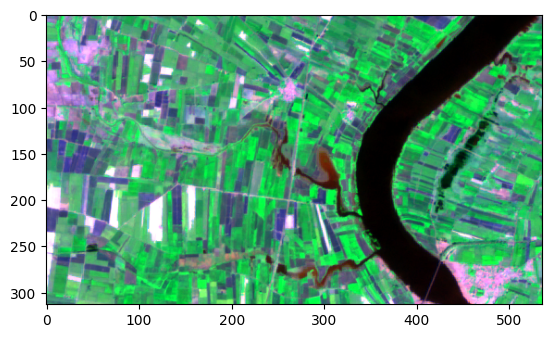

In [13]:
plt.figure()
plt.imshow(images_open_test[0])
plt.show()

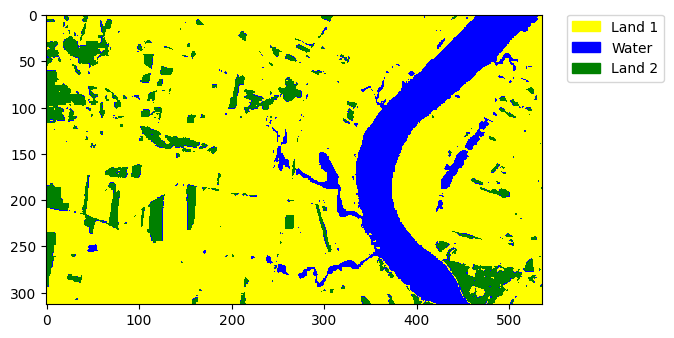

In [14]:
import matplotlib.patches as mpatches
import matplotlib.colors as colo

# Visualizing the clusters formed for pre-flood image
plt.figure()

custom = colo.ListedColormap(["yellow", "blue", "green"])

im_before = plt.imshow(test_kmeans, cmap = custom)

values = np.unique(test_kmeans.ravel())

# Getting the colors of the values, according to the colormap used by imshow
colors = [im_before.cmap(im_before.norm(value)) for value in values]

# Creating a patch (proxy artist) for every color 
labels = ["Land 1", "Water", "Land 2"]
patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
# Putting those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [15]:
# Applying model on test image after flood

test_kmeans2 = trained_kmeans.predict(reshaped_images_test[1])
clusterCountA = np.bincount(test_kmeans2)

test_kmeans2 = test_kmeans2.reshape(images_open_test[1][:, :, 0].shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


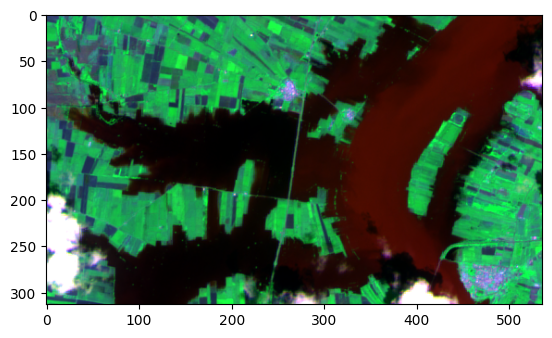

In [16]:
plt.figure()
plt.imshow(images_open_test[1])
plt.show()

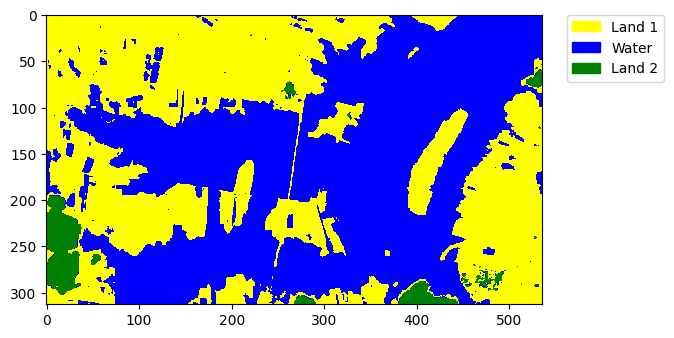

In [17]:
# Visualizing the clusters formed for post-flood image
plt.figure()

custom = colo.ListedColormap(["yellow", "blue", "green"])

im_after = plt.imshow(test_kmeans2, cmap = custom)

values = np.unique(test_kmeans2.ravel())

# Getting the colors of the values, according to the colormap used by imshow
colors = [im_after.cmap(im_after.norm(value)) for value in values]

# Creating a patch (proxy artist) for every color 
labels = ["Land 1", "Water", "Land 2"]
patches = [ mpatches.Patch(color=colors[i], label=labels[i]) for i in range(len(values)) ]
# Putting those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

In [18]:
#Calculating the water percentage in the pre-flood image
sum_before = np.sum(clusterCountP)
water_perc_before = clusterCountP[1]/sum_before * 100
water_perc_before

12.181703304563445

In [19]:
#Calculating the water percentage in the post-flood image
sum_after = np.sum(clusterCountA)
water_perc_after = (clusterCountA[1]/sum_after) * 100
water_perc_after

53.31588860807782

In [20]:
# Calculating Flood Increase
flood_increase = water_perc_after - water_perc_before
flood_increase

41.13418530351437

# DBSCAN Clustering

In [17]:
#Importing the necessary libraries

from osgeo import gdal
import numpy as np
import matplotlib.pyplot as plt

#  calculating Cumulative Count Cut 

def scaleCCC(x):
    return((x - np.nanpercentile(x, 2))/(np.nanpercentile(x, 98) - np.nanpercentile(x,2)))

# Opening the satellite images

img = gdal.Open("./ALL_FLOOD/1_P.tif")

# Extracting individual bands(4,8,12) from the uploaded images

band4_before = img.GetRasterBand(1).ReadAsArray()
band8_before = img.GetRasterBand(2).ReadAsArray()
band12_before = img.GetRasterBand(3).ReadAsArray()

ds_before = None

ccc4_before = scaleCCC(band4_before)
ccc8_before = scaleCCC(band8_before)
ccc12_before = scaleCCC(band12_before)

# Creating a new images by combining the three bands
 
before_img = np.dstack((ccc4_before,ccc8_before,ccc12_before))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


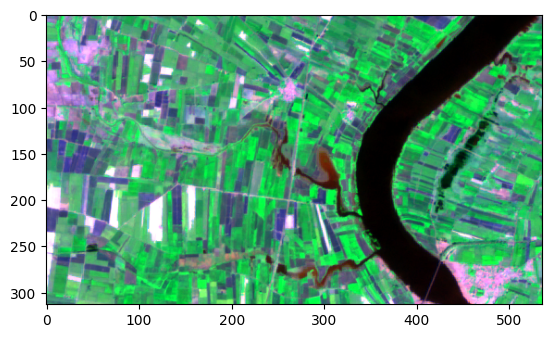

In [18]:
# Visualizing the image

plt.figure()
plt.imshow(before_img)
plt.show()

In [19]:
# Reshaping the images

new_before_shape = (before_img.shape[0] * before_img.shape[1], before_img.shape[2])
X_before = before_img[:, :, :3].reshape(new_before_shape)

In [6]:
X_before = combined_image2

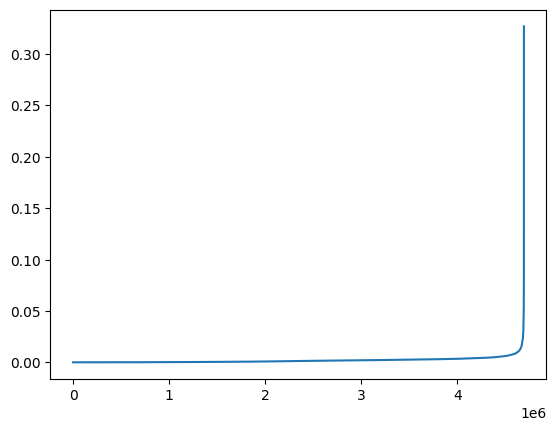

In [ ]:
# Running KNN to get optimal epsilon value

from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt

neighbors = NearestNeighbors(n_neighbors=80)
neighbors_fit = neighbors.fit(X_before)
distances, indices = neighbors_fit.kneighbors(X_before)

distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)

In [8]:
# Running DBSCAN Algorithm on train image

from sklearn.cluster import DBSCAN

X_before=combined_image2
dbscan = DBSCAN(eps=0.02, min_samples=80)
trained_dbscan= dbscan.fit(X_before)
X_cluster_before = dbscan.labels_
# X_cluster_before = X_cluster_before.reshape(before_img[:, :, 0].Xshape)

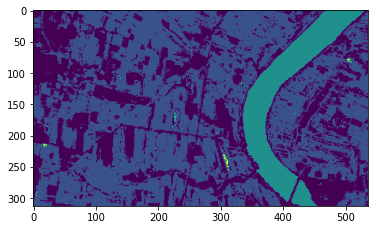

In [ ]:
import matplotlib.patches as mpatches
import matplotlib.colors as colo

# Visualizing the clusters formed for pre-flood image

plt.figure()
im_before = plt.imshow(X_cluster_before)
plt.show()

In [9]:
# Calculating water percentage for before image

arr_before = np.unique(X_cluster_before, return_counts=True)
key_before, val_before = arr_before
water_before = val_before[2]/(val_before[1] + val_before[2] + val_before[3] + val_before[4]) * 100
print("%.2f" %water_before, "%")

18.91 %


In [7]:
# Opening the satellite images
img = gdal.Open("1_A.tif")

# Extracting individual bands(4,8,12) from the uploaded images
band4_after = img.GetRasterBand(1).ReadAsArray()
band8_after = img.GetRasterBand(2).ReadAsArray()
band12_after = img.GetRasterBand(3).ReadAsArray()

ds_after = None

ccc4_after = scaleCCC(band4_after)
ccc8_after = scaleCCC(band8_after)
ccc12_after = scaleCCC(band12_after)

# Creating a new images by combining the three bands 
after_img = np.dstack((ccc4_after,ccc8_after,ccc12_after))

AttributeError: 'NoneType' object has no attribute 'GetRasterBand'

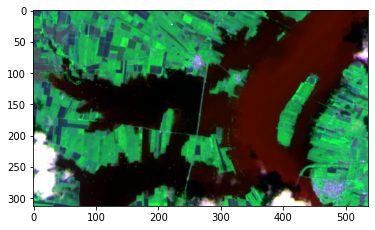

In [ ]:
# Visualizing the image

plt.figure()
plt.imshow(after_img)
plt.show()

In [8]:
# Reshaping the images
 
new_after_shape = (after_img.shape[0] * after_img.shape[1], after_img.shape[2])
X_after = after_img[:, :, :3].reshape(new_after_shape)

NameError: name 'after_img' is not defined

In [9]:
# Running DBSCAN Algorithm on test image

test_dbscan = trained_dbscan.fit_predict(X_after)
X_cluster_after = dbscan.labels_
X_cluster_after = X_cluster_after.reshape(after_img[:, :, 0].shape)

NameError: name 'trained_dbscan' is not defined

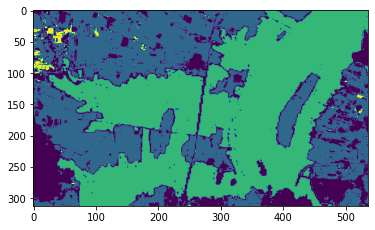

In [ ]:
# Visualizing the clusters formed for post-flood image

plt.figure()
im_before = plt.imshow(X_cluster_after)
plt.show()

In [ ]:
core_samples_mask = np.zeros_like(dbscan.labels_, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True
labels = dbscan.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

Estimated number of clusters: 3
Estimated number of noise points: 32532


In [ ]:
# Calculating water percentage for after image

arr_after = np.unique(X_cluster_after, return_counts=True)
key_after, val_after = arr_after
water_after = val_after[2]/(val_after[1] + val_after[2] + val_after[3]) * 100
print("%.2f" %water_after, "%")

56.45 %


In [ ]:
# Calculating Flood Increase

dbscan_flood_increase = water_after - water_before
print("%.2f" %dbscan_flood_increase, "%")

42.23 %


In [ ]:
pip install pyclustering

     ---------------------------------------- 2.6/2.6 MB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Running setup.py install for pyclustering: started
  Running setup.py install for pyclustering: finished with status 'done'
Note: you may need to restart the kernel to use updated packages.


  DEPRECATION: pyclustering is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559


In [20]:
from pyclustering.cluster.clarans import clarans
from pyclustering.utils import timedcall

data = X_before.tolist()
clarans_instance = clarans(data, 3, 2, 3)
#calls the clarans method 'process' to implement the algortihm
(ticks, result) = timedcall(clarans_instance.process);
print("Execution time : ", ticks, "\n");

#returns the clusters 
clusters = clarans_instance.get_clusters();

#returns the mediods 
medoids = clarans_instance.get_medoids();


print("Index of the points that are in a cluster : ",clusters)
print("The index of medoids that algorithm found to be best : ",medoids)

AttributeError: module 'sklearn' has no attribute 'metrics'